In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

### Read RADAR and image x,y coordinates from csv file

In [2]:
image_xy = pd.read_csv('./image_xy.csv')
radar_xy = pd.read_csv('./radar_xy.csv')

In [3]:
radar_x = radar_xy['x'].values
radar_y = radar_xy['y'].values
image_x = image_xy['x'].values
image_y = image_xy['y'].values

### Split the data to train and test dataset 

In [4]:
radar_data = [[x,y] for x,y in zip(radar_x,radar_y)]
# radar_data

In [5]:
image_data = [[x,y] for x,y in zip(image_x,image_y)]

In [6]:
radar_data = np.array(radar_data)
image_data = np.array(image_data)

radar_data_tensor = torch.Tensor(radar_data) # transform to torch tensor
image_data_tensor = torch.Tensor(image_data)

dataset = TensorDataset(radar_data_tensor,image_data_tensor) # create your datset
dataloader = DataLoader(dataset) # create your dataloader

In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)
len(dataset),len(train_loader),len(test_loader)

(12, 9, 3)

#### Define the autoencoder

In [9]:
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(2,1),
			torch.nn.ReLU(),
			torch.nn.Linear(1,64),
			torch.nn.ReLU(),
			torch.nn.Linear(64,36),
			torch.nn.ReLU(),
			torch.nn.Linear(36,18),
			torch.nn.ReLU(),
			torch.nn.Linear(18,80)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(80,18),
			torch.nn.ReLU(),
			torch.nn.Linear(18,36),
			torch.nn.ReLU(),
			torch.nn.Linear(36,16),
			torch.nn.ReLU(),
			torch.nn.Linear(16,2),
			torch.nn.ReLU(),
			torch.nn.Linear(2,2)
			# torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded

In [10]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
# loss_function = torch.nn.MSELoss() 
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)

In [11]:
epochs = 20
train_losses = []
test_losses = []
inference_time = []
training_time = []
for epoch in range(epochs):
    ## Train model
    i = 0
    train_loss = 0
    model.train()
    start_train = time.perf_counter()
    for (radar_xy,image_xy) in train_loader:
        # Output of Autoencoder
        reconstructed = model(radar_xy)
        # Calculating the loss function
        loss = loss_function(reconstructed, image_xy)
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()
        i += 1
        train_loss += loss.detach().numpy()
    end_train = time.perf_counter()
    training_time.append(end_train-start_train)
    print(f"Epoch:{epoch} Frames:{i} Training loss:{loss}")
    train_losses.append(train_loss)
    ## Test model
    model.eval()
    i = 0
    test_loss = 0
    with torch.no_grad():
        for (radar_xy,image_xy) in test_loader:
            start = time.perf_counter()
            reconstructed = model(radar_xy)
            end = time.perf_counter()
            inference_time.append(end-start)
            loss = loss_function(reconstructed, image_xy)
            i += 1
            test_loss += loss.detach().numpy()
        print(f"Epoch:{epoch} Frames:{i} Testing loss:{loss}")
        test_losses.append(test_loss)

Epoch:0 Frames:9 Training loss:1396.73193359375
Epoch:0 Frames:3 Testing loss:2553.39453125
Epoch:1 Frames:9 Training loss:1396.73193359375
Epoch:1 Frames:3 Testing loss:2553.39453125
Epoch:2 Frames:9 Training loss:1396.73193359375
Epoch:2 Frames:3 Testing loss:2553.39453125
Epoch:3 Frames:9 Training loss:1396.73193359375
Epoch:3 Frames:3 Testing loss:2553.39453125
Epoch:4 Frames:9 Training loss:1396.73193359375
Epoch:4 Frames:3 Testing loss:2553.39453125
Epoch:5 Frames:9 Training loss:1396.73193359375
Epoch:5 Frames:3 Testing loss:2553.39453125
Epoch:6 Frames:9 Training loss:1396.73193359375
Epoch:6 Frames:3 Testing loss:2553.39453125
Epoch:7 Frames:9 Training loss:1396.73193359375
Epoch:7 Frames:3 Testing loss:2553.39453125
Epoch:8 Frames:9 Training loss:1396.73193359375
Epoch:8 Frames:3 Testing loss:2553.39453125
Epoch:9 Frames:9 Training loss:1396.73193359375
Epoch:9 Frames:3 Testing loss:2553.39453125
Epoch:10 Frames:9 Training loss:1396.73193359375
Epoch:10 Frames:3 Testing loss:

#### Plot the training and testing loss

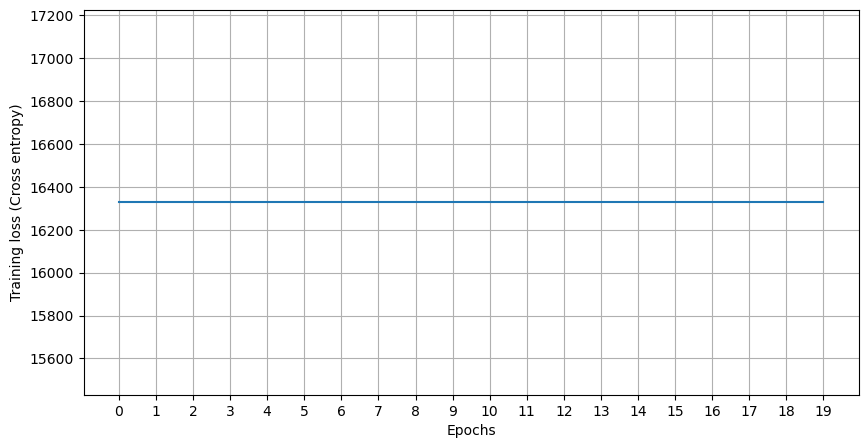

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Training loss (Cross entropy)")
plt.xticks(np.arange(epochs))
plt.show()

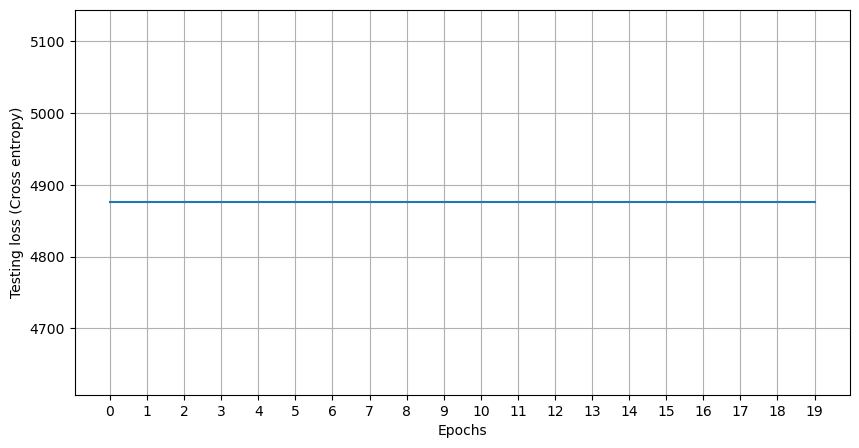

In [13]:
plt.figure(figsize=(10,5))
plt.plot(test_losses)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Testing loss (Cross entropy)")
plt.xticks(np.arange(epochs))
plt.show()

In [14]:
### Average inference time 
np.mean(inference_time)

0.00012703271543917555

In [15]:
### Average training time per epoch 
np.mean(training_time)

0.0075237566430587325